In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import regex
from sklearn.linear_model import LogisticRegressionCV
import pickle


CSV_FILE =  "D:/ml_data/pubmed/pmc_result_vaccine_allergy_1year.csv" # "example_data.csv"
PARQUET_FILE = CSV_FILE.replace('.csv', '.parquet')

if os.path.exists(PARQUET_FILE):
    article_table = pd.read_parquet(PARQUET_FILE)
else:
    from sentence_transformers import SentenceTransformer
    sentxformer = SentenceTransformer('all-MiniLM-L6-v2')

    article_table = pd.read_csv(CSV_FILE).fillna('')
    
    article_table['section_path_vector'] = sentxformer.encode(article_table['section_path'].values).tolist()
    article_table['text_vector'] = sentxformer.encode(article_table['text'].values).tolist()
    
    article_table.to_parquet(PARQUET_FILE)


print(f"article_table has {len(article_table)} rows.")

article_table.head()

article_table has 195695 rows.


,pmid,paragraph_number,section_path,text,section_path_vector,text_vector
0,36321821,0,Title,Diagnostic accuracy of vaccine and vaccine exc...,"[-0.07106374204158783, 0.06475027650594711, -0...","[0.0653635561466217, -0.0196632519364357, -0.0..."
1,36321821,1,Abstract,For persons with immediate allergic reactions ...,"[-0.07030734419822693, 0.08017940074205399, 0....","[0.047091107815504074, -0.05435621738433838, -..."
2,36321821,2,INTRODUCTION,Over 12.2 billion COVID‐19 vaccine doses have ...,"[-0.045066457241773605, 0.058423690497875214, ...","[0.037329141050577164, -0.08426067233085632, -..."
3,36321821,3,INTRODUCTION,In the face of uncertainty regarding new vacci...,"[-0.045066457241773605, 0.058423690497875214, ...","[0.028730379417538643, -0.02857697196304798, -..."
4,36321821,4,INTRODUCTION,To better inform the evidence base regarding s...,"[-0.045066457241773605, 0.058423690497875214, ...","[0.008769247680902481, -0.03468548506498337, -..."


In [2]:
h1_list = [ p.split(' || ')[0].upper() for p in article_table['section_path'] ]

h1_list = [ regex.sub(r'(STAR\★|^\d+.? )', '', p0) for p0 in h1_list ]  # remove 'STAR★' and section numbers

# standardize on METHODS
h1_list = [ 'METHODS' if 'METHOD' in p0 else p0 for p0 in h1_list ]

# standardize on CONCLUSION
h1_list = [ 'CONCLUSIONS' if 'CONCLUSION' in p0 else p0 for p0 in h1_list ]

# Note that we do NOT do this for 'RESULTS AND DISCUSSION'; we want to keep these separate where possible.


Counter(h1_list).most_common()

[('METHODS', 43958),
 ('RESULTS', 37225),
 ('DISCUSSION', 27160),
 ('INTRODUCTION', 17977),
 ('ABSTRACT', 9446),
 ('TITLE', 4713),
 ('CONCLUSIONS', 3670),
 ('RESULTS AND DISCUSSION', 2424),
 ('BACKGROUND', 998),
 ('AUTHOR CONTRIBUTIONS', 750),
 ('SUPPLEMENTARY INFORMATION', 599),
 ('DATA AVAILABILITY STATEMENT', 453),
 ('EXPERIMENTAL SECTION', 385),
 ('ETHICS STATEMENT', 382),
 ('CASE PRESENTATION', 366),
 ('TREATMENT', 257),
 ('DIAGNOSIS', 254),
 ('CASE REPORT', 223),
 ('DECLARATION OF COMPETING INTEREST', 198),
 ('CONFLICT OF INTEREST', 195),
 ('FUNDING', 195),
 ('CONCLUDING REMARKS', 169),
 ('FUNGAL INFECTIONS', 162),
 ('SPECIAL CIRCUMSTANCES', 131),
 ('MAIN TEXT', 127),
 ('LITERATURE REVIEW', 126),
 ('ETIOLOGIC DIAGNOSIS: IDENTIFICATION OF THE CULPRIT DRUG', 121),
 ('DECLARATION OF INTERESTS', 121),
 ('ASSESSMENT', 120),
 ('MAIN', 118),
 ('RESULTS/DISCUSSION', 114),
 ('EXPERIMENTAL PROCEDURES', 113),
 ('RESULT', 107),
 ('LIMITATIONS', 107),
 ('SYSTEMIC THERAPIES', 104),
 ('ZOONOSES

In [3]:
targets = [t[0] for t in Counter(h1_list).most_common(5)]
targets

['METHODS', 'RESULTS', 'DISCUSSION', 'INTRODUCTION', 'ABSTRACT']

In [4]:
keep_rows = [ t in targets for t in h1_list ]

flag_table = pd.DataFrame.from_dict( { t: [h==t for h in h1_list] for t in targets }, orient='columns')[keep_rows]
len(flag_table)

135766

In [5]:
X = [v for v in article_table['text_vector'][keep_rows].values]
len(X)

135766

In [6]:
MODEL_FILE = 'logreg_models.pkl'

if os.path.exists(MODEL_FILE):
    with open(MODEL_FILE, 'rb') as model_fh_in:
        models = pickle.load(model_fh_in)
else:
    models = {}
    for flag_col in flag_table.columns:
        print(f"Fitting model for '{flag_col}'")
        
        clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)
        clf.fit(X, flag_table[flag_col])
        models[flag_col] = clf

    with open(MODEL_FILE, 'wb') as model_fh_out:
        pickle.dump(models, model_fh_out)


# Mean cross-validation AUC for each model
{ t: np.mean([np.max(v) for v in mdl.scores_[True]]) for t, mdl in models.items() }


Fitting model for 'METHODS'
Fitting model for 'RESULTS'
Fitting model for 'DISCUSSION'
Fitting model for 'INTRODUCTION'
Fitting model for 'ABSTRACT'


{'METHODS': 0.9456549202393383,
 'RESULTS': 0.853207639034571,
 'DISCUSSION': 0.8503458472540654,
 'INTRODUCTION': 0.8981477261941654,
 'ABSTRACT': 0.8524947672673149}

In [7]:
{'METHODS': 0.9351648188172857,
 'RESULTS': 0.8621212765640951,
 'DISCUSSION': 0.8207674389096752,
 'INTRODUCTION': 0.830585773685879,
 'ABSTRACT': 0.8328962784008496,
 'TITLE': 0.987145491259753,
 'CONCLUSIONS': 0.8384550362602508}

{'METHODS': 0.9351648188172857,
 'RESULTS': 0.8621212765640951,
 'DISCUSSION': 0.8207674389096752,
 'INTRODUCTION': 0.830585773685879,
 'ABSTRACT': 0.8328962784008496,
 'TITLE': 0.987145491259753,
 'CONCLUSIONS': 0.8384550362602508}

# Predict adverse events

In [10]:
Counter([ p for p in article_table['section_path'] if regex.search('adverse', p, regex.IGNORECASE)]).most_common()

[('Oversight and monitoring || Adverse event reporting and harms {22}', 24),
 ('Results || Adverse events', 17),
 ('Results ||  F- Adverse Effects (Non-infections and Non-malignancy)', 13),
 ('2. Methods || 2.7. Adverse Events, Diseases, etc.', 10),
 ('Design || Adverse events reporting and analysis', 10),
 ('Results || Population characteristics of SLE patients || Adverse events in SLE and comparisons with other subgroups',
  9),
 ('3. Results || 3.1. Safety of the Immunotherapy  || 3.1.1. Adverse Reactions during Immunotherapy',
  8),
 ('Materials and methods || Reported adverse events data', 8),
 ('Individual drug groups implicated in reactions || Drugs more rarely involved in preoperative, perioperative, and postoperative adverse reactions',
  8),
 ('2. Methods || 2.3. Outcome Data || 2.3.2. Part II—Allergen-Specific Immunotherapy-Induced Adverse Events',
  8),
 ('Imaging of immune-related adverse events || Thoracic toxicities', 8),
 ('Gut dysbiosis in children with ALL || Adverse 

In [18]:
patterns = ['adverse', 'population', 'treatment']

get_mean_xval_score_for_binary_classifier = lambda clf: np.mean([np.max(v) for v in clf.scores_[True]])


pattern_models = {}
X_all = [v for v in article_table['text_vector'].values]
for pat in patterns:
    print(f"Fitting model for pattern '{pat}'")
    
    y_pat = [ 1 if regex.search(pat, p, regex.IGNORECASE) else 0 for p in article_table['section_path'] ]
    
    clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)
    clf.fit(X_pat, y_pat)
    print(pat, get_mean_xval_score_for_binary_classifier(clf))
    pattern_models[pat] = clf


Fitting model for pattern 'adverse'
adverse 0.9105883095030529
Fitting model for pattern 'population'
population 0.8373245630511568
Fitting model for pattern 'treatment'
treatment 0.8446813142663533


In [38]:
pattern_flag_dict = {}

# Note that here we are looking for the pattern only in the section path, not in the text itself.
for pat in patterns:
    y_pat = [ 1 if regex.search(pat, p, regex.IGNORECASE) else 0 for p in article_table['section_path'] ]
    pattern_flag_dict[pat] = y_pat

pattern_flags = pd.DataFrame.from_dict(pattern_flag_dict, orient='columns')
pattern_flags

,adverse,population,treatment
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
195690,0,0,0
195691,0,0,0
195692,0,0,0
195693,0,0,0


In [19]:
{ t: get_mean_xval_score_for_binary_classifier(mdl) for t, mdl in pattern_models.items() }

{'adverse': 0.9105883095030529,
 'population': 0.8373245630511568,
 'treatment': 0.8446813142663533}

# Score all cases with all models


In [35]:
X_all = [v for v in article_table['text_vector'].values]
model_scores = {}
for target, model in models.items():
    model_scores[target] = model.predict_proba(X_all)[:,1]

for pattern, model in pattern_models.items():
    model_scores[pattern] = model.predict_proba(X_all)[:,1]

scores_df = pd.DataFrame.from_dict(model_scores, orient='columns')

scores_df

,METHODS,RESULTS,DISCUSSION,INTRODUCTION,ABSTRACT,adverse,population,treatment
0,0.392729,0.013144,0.106685,0.164764,0.001212,0.001405,0.004748,0.001212
1,0.467891,0.090845,0.154400,0.037906,0.002511,0.003029,0.003403,0.002511
2,0.008582,0.248929,0.385940,0.192315,0.002386,0.003355,0.001390,0.002386
3,0.466348,0.035729,0.327583,0.095015,0.002845,0.003805,0.009403,0.002845
4,0.571138,0.023829,0.470320,0.054129,0.003004,0.001542,0.003134,0.003004
...,...,...,...,...,...,...,...,...
195690,0.008612,0.025737,0.279532,0.604809,0.040869,0.000782,0.002373,0.040869
195691,0.002589,0.139488,0.668194,0.223457,0.024458,0.000778,0.004517,0.024458
195692,0.000404,0.140186,0.455792,0.193495,0.006777,0.000665,0.008123,0.006777
195693,0.000140,0.411427,0.523791,0.288862,0.009735,0.001574,0.006667,0.009735


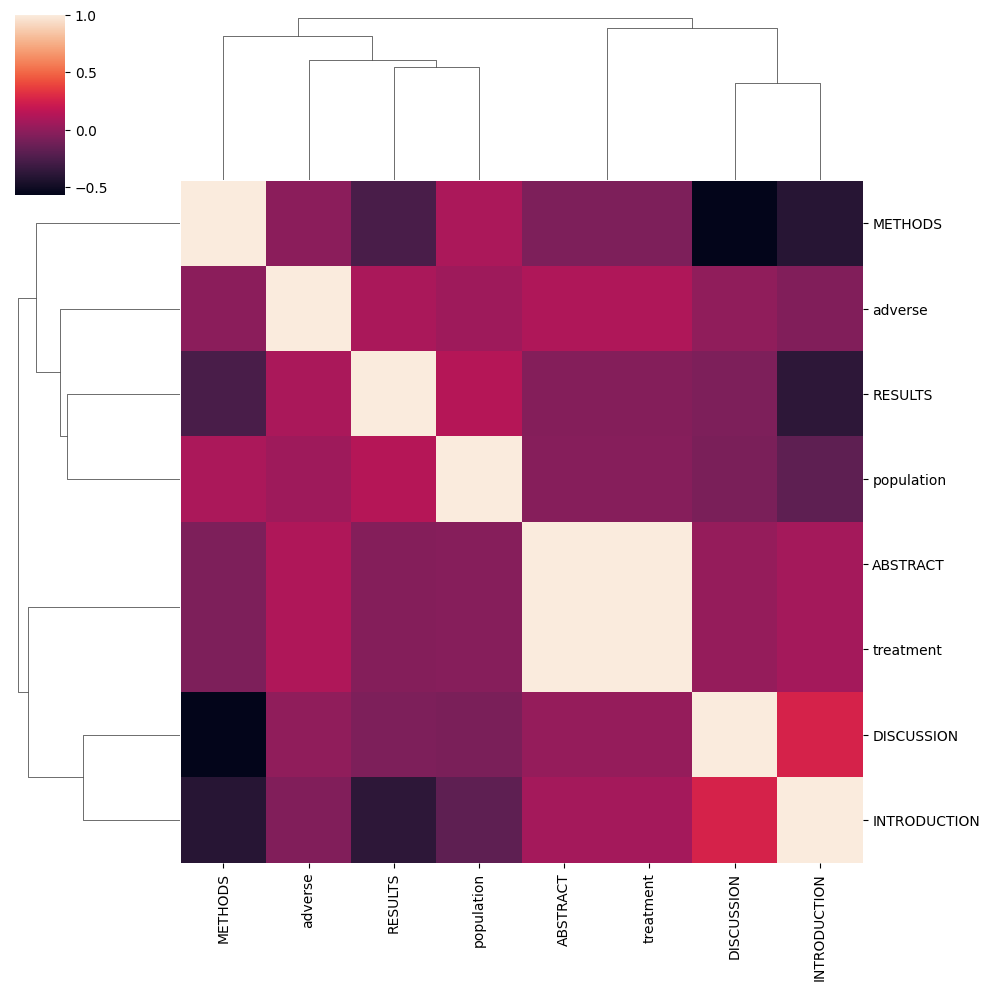

In [37]:
import seaborn as sns

sns.clustermap(scores_df.corr())

# To do:
* use models to score cases that do not have any of the standard labels. Which of the non-standard labels correlate with scores from the standard labels? Discussion vs. Conclusion?
* How are the scores for each model distributed for each label? Start by computing model means for each flag value.
* Use a decision tree to classify paragraphs using a set of general model scores as features; semi-interpretability.

* predict semantic model scores from tags with DT round robin => combine soft labels to get something predictable (nonlinear conditional combinations)

In [78]:
def get_bucket(id, num_buckets=3):
    import hashlib
    
    m = hashlib.sha256()
    m.update(id.encode())
    return int( m.hexdigest(), 16) % num_buckets
    

article_table['bucket'] = [get_bucket(pmid, 3) for pmid in article_table['pmid'] ]
Counter(article_table['bucket'])

Counter({2: 68442, 0: 64091, 1: 63162})

In [139]:
train1 = article_table['bucket']==1  # [ 1 if b==1 else 0 for b in article_table['bucket'] ]
train2 = article_table['bucket']==2
test = article_table['bucket']==0

X_all = [v for v in article_table['text_vector'].values ]

level1_models = {}
for target in targets:
    print(f"Fitting level 1 model for '{target}'")
    train1_idx = np.where(train1==1)[0]
    flags = np.array([h==target for h in h1_list])[train1_idx]
    clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)
    clf.fit(np.array(X_all)[train1], flags)
    level1_models[flag_col] = clf

with open('level1_models.pkl', 'wb') as model_fh_out:
    pickle.dump(models, model_fh_out)

Fitting level 1 model for 'METHODS'
Fitting level 1 model for 'RESULTS'
Fitting level 1 model for 'DISCUSSION'
Fitting level 1 model for 'INTRODUCTION'
Fitting level 1 model for 'ABSTRACT'


In [136]:
len([v for v in np.where(train1==1)[0]] )

train1_idx = np.where(train1==True)[0]
len(train1_idx) # 63162

# len(np.where(train1==True)[0]) # 63162

len(h1_list)  # 195695

flags = [h==target for h in h1_list]
len(flags) #195695
sum(flags) #43958

np.array(train1_idx)
len(np.array(flags)[np.array(train1_idx)])

h1_list == target

False

In [90]:
[ 1 if x else 0 for x in train1 ]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,


In [55]:

# Predict flags from all model scores using a decision tree.

pat = 'population'
y = pattern_flags[pat]

from sklearn import tree
dt_clf = tree.DecisionTreeClassifier(max_depth=1)
dt_clf = dt_clf.fit(scores_df, y)

dt_scores = dt_clf.predict_proba(scores_df)[:,1]

np.sum(dt_scores) # for 'abstract' sum=689.0 with any max_depth

1788.0000000000002